## 1. Proyecto 3.


### 1.1 Tabla Amortización
> Calcularemos 3 diferentes escuelas, de las cuales queremos sacar un credito

### 1.2 Introducción
> En el siguiente codigo intentaremos determinar que escuela tiene el mayor credito. Un estudiante graduado de preparatoria quiere estudiar Ingenieria Industrial, se acaba de graduar y esta viendo a que Universidad entrar sin embargo, no puede pagarla sin un credito por lo que, esta buscando uno en las siguientes tres escuelas(Tec, Iteso y UP). Las cuales le ofrecieron el siguiente crédito.


### 1.3 Objetivos.
> - Hacer una tabla de amortización.
> - Calcular interés.
> - Simular la proyección del precio dado.
> #### 1.1 Objetivo general.
>  - Definir cual credito le combiene más al estudiante.
>  - Comparar cual credito es mejor

In [36]:
!conda install -c conda-forge yfinance -y

SyntaxError: invalid syntax (1651182941.py, line 2)

In [43]:
!conda install -c anaconda pandas-datareader -y
!pip install numpy-financial

Solving environment: ...working... done

# All requested packages already installed.



DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/main/win-64/current_repodata.json HTTP/1.1" 304 0
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/msys2/noarch/current_repodata.json HTTP/1.1" 304 0
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/r/win-64/current_repodata.json HTTP/1.1" 304 0
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/msys2/win-64/current_repodata.json HTTP/1.1" 304 0
DEBUG

In [66]:
#Importar librerias
import pandas as pd
import numpy as np
from datetime import date
import numpy_financial as npf

In [67]:
#Datos TEC
Interest_Rate = 0.05
Years = 20
Payments_Year = 12
Principal = 100000
Addl_Princ = 50
start_date = (date(2023,11,11))

#Calcular datos de la tabla
pmt = npf.pmt(Interest_Rate/Payments_Year, Years*Payments_Year, Principal)

In [69]:
# calcular periodo
per = 1

# Calcular interes
ipmt = npf.ipmt(Interest_Rate/Payments_Year, per, Years*Payments_Year, Principal)

# Calcular dato principal
ppmt = npf.ppmt(Interest_Rate/Payments_Year, per, Years*Payments_Year, Principal)

#print(ipmt, ppmt)

In [70]:
rng = pd.date_range(start_date, periods=Years * Payments_Year, freq='MS')
rng.name = "Payment_Date"

In [71]:
df = pd.DataFrame(index=rng,columns=['Payment', 'Principal', 'Interest', 'Addl_Principal', 'Balance'], dtype='float')
df.reset_index(inplace=True)
df.index += 1
df.index.name = "Period"

In [131]:
#Definir para la tabla
df["Payment"] = npf.pmt(Interest_Rate/Payments_Year, Years*Payments_Year, Principal)
df["Principal"] = npf.ppmt(Interest_Rate/Payments_Year, df.index, Years*Payments_Year, Principal)
df["Interest"] = npf.ipmt(Interest_Rate/Payments_Year, df.index, Years*Payments_Year, Principal)

# Convertir a negativos
df["Addl_Principal"] = -Addl_Princ
df = df.round(2)

#Codigo para definir
df["Cumulative_Principal"] = (df["Principal"] + df["Addl_Principal"]).cumsum()
df["Cumulative_Principal"] = df["Cumulative_Principal"].clip(lower=-Principal)
df["Curr_Balance"] = Principal + df["Cumulative_Principal"]

In [132]:
df.index += 1
df.index.name = "Cumulative_Principal"
df.index += 1
df.index.name = "Curr_Balance"
df["Cumulative_Principal"] = df["Cumulative_Principal"].clip(lower=-Principal)
#aqui solo estas poniendo como limite principal

df["Curr_Balance"] = Principal + df["Cumulative_Principal"]

In [133]:
#Dar valores del valance
last_payment = df.query("Curr_Balance <= 0")["Curr_Balance"].idxmax(axis=0, skipna=True)
df.loc[last_payment]

Payment_Date            2041-12-01 00:00:00
Payment                             -659.96
Principal                           -622.64
Interest                             -37.32
Addl_Principal                          -50
Balance                                 NaN
Cumulative_Principal              -100000.0
Curr_Balance                            0.0
Name: 229, dtype: object

In [118]:
df.loc[last_payment, "Principal"] = -(df.loc[last_payment-1, "Curr_Balance"])
df.loc[last_payment, "Payment"] = df.loc[last_payment, ["Principal", "Interest"]].sum()
df.loc[last_payment, "Addl_Principal"] = 0
df = df.loc[0:last_payment]

In [119]:
def amortization_table(interest_rate, years, payments_year, principal, addl_principal=0, start_date=date.today()):
    # poner negativos en addl_principal
    if addl_principal > 0:
        addl_principal = -addl_principal
    
    #crear index de fecha de pago
    rng = pd.date_range(start_date, periods=years * payments_year, freq='MS')
    rng.name = "Payment_Date"
    
    # Crear la amortización del data frame
    df = pd.DataFrame(index=rng,columns=['Payment', 'Principal', 'Interest', 
                                         'Addl_Principal', 'Curr_Balance'], dtype='float')
    
    # Incluir index al period (start at 1 not 0)
    df.reset_index(inplace=True)
    df.index += 1
    df.index.name = "Period"
    
    # Calcular payment, principal and interests amounts using built in Numpy functions
    per_payment = npf.pmt(interest_rate/payments_year, years*payments_year, principal)
    df["Payment"] = per_payment
    df["Principal"] = npf.ppmt(interest_rate/payments_year, df.index, years*payments_year, principal)
    df["Interest"] = npf.ipmt(interest_rate/payments_year, df.index, years*payments_year, principal)
        
    # Redondear
    df = df.round(2) 
    
     # Incluir pagos adicionales
    df["Addl_Principal"] = addl_principal
    
    # Asegurarse que el cumulative principal, no sea mayor al pago
    df["Cumulative_Principal"] = (df["Principal"] + df["Addl_Principal"]).cumsum()
    df["Cumulative_Principal"] = df["Cumulative_Principal"].clip(lower=-principal)
    
    # Calcular el balance en cada periodo
    df["Curr_Balance"] = principal + df["Cumulative_Principal"]
    
    # Determinar último pago
    try:
        last_payment = df.query("Curr_Balance <= 0")["Curr_Balance"].idxmax(axis=1, skipna=True)
    except ValueError:
        last_payment = df.last_valid_index()
    
    last_payment_date = "{:%m-%d-%Y}".format(df.loc[last_payment, "Payment_Date"])
        
    # Si tenemos pagos adicionales truncar la columna:
    if addl_principal != 0:
                
        # Quitar los pagos extra 
        df = df.loc[0:last_payment].copy()
        
        # Calcular princpal en ultima columna
        df.loc[last_payment, "Principal"] = -(df.loc[last_payment-1, "Curr_Balance"])
        
         # Calcular el pago total en ultima fila
        df.loc[last_payment, "Payment"] = df.loc[last_payment, ["Principal", "Interest"]].sum()
        
        # Determinar a zero additional principal
        df.loc[last_payment, "Addl_Principal"] = 0
        
    # POner la info en un Data frame
    payment_info = (df[["Payment", "Principal", "Addl_Principal", "Interest"]]
                    .sum().to_frame().T)
       
    # Formatear el Date DataFrame
    payment_details = pd.DataFrame.from_dict(dict([('payoff_date', [last_payment_date]),
                                               ('Interest Rate', [interest_rate]),
                                               ('Number of years', [years])
                                              ]))
    # Añadir columna mostrando los pagos 
    # Combinar addl principal con el pago principal para tener los pagos totales
    payment_details["Period_Payment"] = round(per_payment, 2) + addl_principal
    
    payment_summary = pd.concat([payment_details, payment_info], axis=1)
    return df, payment_summary
    

In [153]:
schedule1, stats1 = amortization_table(0.05, 17, 12, 100000, addl_principal=50)
schedule2, stats2 = amortization_table(0.06, 20, 12, 100000, addl_principal=200)
schedule3, stats3 = amortization_table(0.07, 15, 12, 100000, addl_principal=0)

# Combinar todos los escenarios
pd.concat([stats1, stats2, stats3], ignore_index=True)

,payoff_date,Interest Rate,Number of years,Period_Payment,Payment,Principal,Addl_Principal,Interest
0,11-01-2040,0.05,17,-778.66,-147921.00,-99274.43,-10150.0,-48645.72
1,11-01-2043,0.06,20,-916.43,-171230.33,-99287.15,-47800.0,-71943.53
2,11-01-2038,0.07,15,-898.83,-161789.40,-99999.99,0.0,-61789.15


Text(0.5, 1.0, 'Pay Off Timelines')

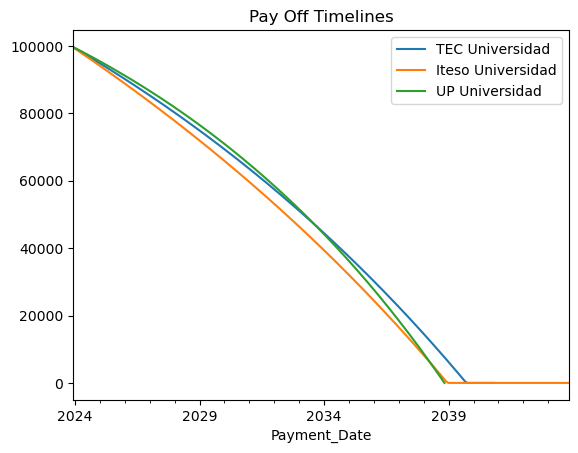

In [154]:
fig, ax = plt.subplots(1, 1)
schedule1.plot(x='Payment_Date', y='Curr_Balance', label="TEC Universidad", ax=ax)
schedule2.plot(x='Payment_Date', y='Curr_Balance', label="Iteso Universidad", ax=ax)
schedule3.plot(x='Payment_Date', y='Curr_Balance', label="UP Universidad", ax=ax)
plt.title("Pay Off Timelines")

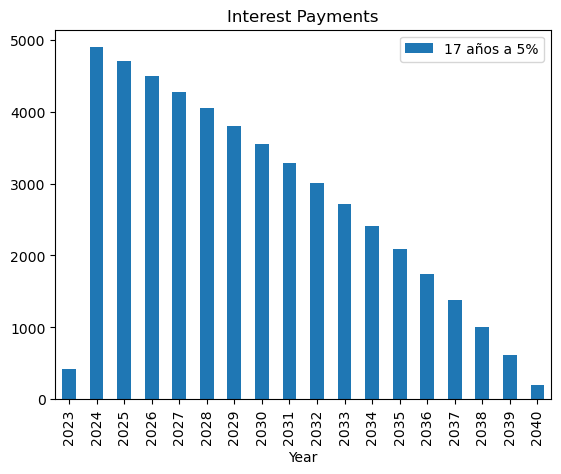

In [155]:
fig, ax = plt.subplots(1, 1)

y1_schedule = schedule1.set_index('Payment_Date').resample("A")["Interest"].sum().abs().reset_index()
y1_schedule["Year"] = y1_schedule["Payment_Date"].dt.year
y1_schedule.plot(kind="bar", x="Year", y="Interest", ax=ax, label="17 años a 5%")

plt.title("Interest Payments");



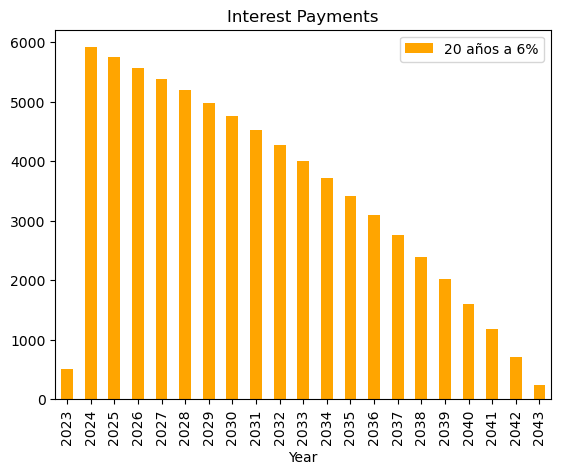

In [156]:
df2 = fig, ax = plt.subplots(1, 1)

y2_schedule = schedule2.set_index('Payment_Date').resample("A")["Interest"].sum().abs().reset_index()
y2_schedule["Year"] = y2_schedule["Payment_Date"].dt.year
y2_schedule.plot(kind="bar", x="Year", y="Interest", ax=ax, color = 'orange', label="20 años a 6%")

plt.title("Interest Payments");

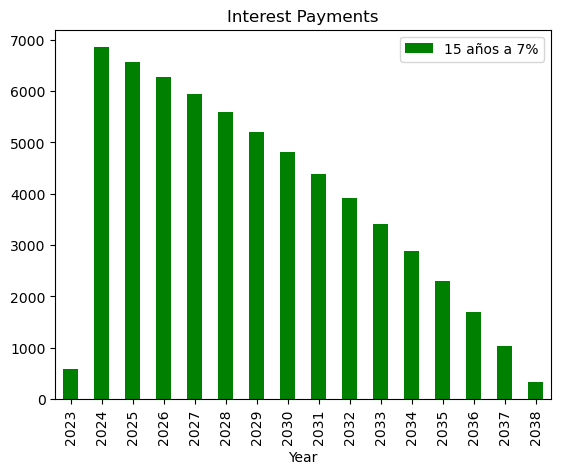

In [157]:
fig, ax = plt.subplots(1, 1)

y3_schedule = schedule3.set_index('Payment_Date').resample("A")["Interest"].sum().abs().reset_index()
y3_schedule["Year"] = y3_schedule["Payment_Date"].dt.year
y3_schedule.plot(kind="bar", x="Year", y="Interest", ax=ax, color = 'green', label="15 años a 7%")

plt.title("Interest Payments");

<Axes: xlabel='Year'>

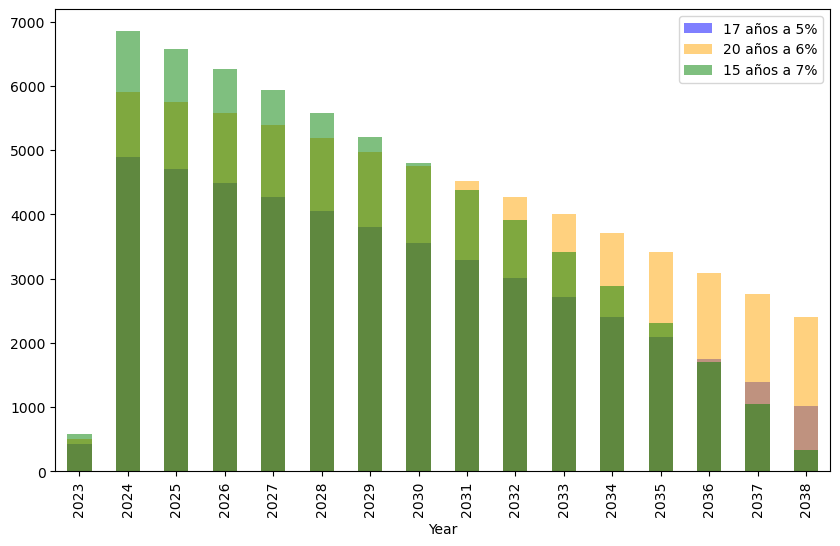

In [161]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

y1_schedule.plot(kind="bar", x="Year", y="Interest", ax=ax, label="17 años a 5%", color='blue', alpha = 0.5)
y2_schedule.plot(kind="bar", x="Year", y="Interest", ax=ax, label="20 años a 6%", color='orange', alpha = 0.5)
y3_schedule.plot(kind="bar", x="Year", y="Interest", ax=ax, label="15 años a 7%", color='green', alpha = 0.5)
